In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
def generate_linear(n=100):
    
    pts = np.random.uniform(0, 1, (n, 2))
    inputs = []
    labels = []
    for pt in pts:
        inputs.append([pt[0], pt[1]])
        distance = (pt[0]-pt[1])/1.414
        if pt[0] > pt[1]:
            labels.append(0)
        else:
            labels.append(1)
    return np.array(inputs), np.array(labels).reshape(n, 1)

def generat_XOR_easy():
    import numpy as np
    inputs = []
    labels = []

    for i in range(11):
        inputs.append([0.1*i, 0.1*i])
        labels.append(0)

        if 0.1* i == 0.5:
            continue

        inputs.append([0.1*i, 1-0.1*i])
        labels.append(1)
    
    return np.array(inputs), np.array(labels).reshape(21, 1)
        

In [3]:
def show_result(x, y, pred_y):
    plt.subplot(1, 2, 1)
    plt.title('Ground Truth', fontsize=18)
    for i in range(x.shape[0]):
        if y[i] == 0:
            plt.plot(x[i][0], x[i][1], 'ro')
        else:
            plt.plot(x[i][0], x[i][1], 'bo')
    
    plt.subplot(1, 2, 2)
    plt.title('Predict result', fontsize=18)
    for i in range(x.shape[0]):
        if pred_y[i] == 0:
            plt.plot(x[i][0], x[i][1], 'ro')
        else:
            plt.plot(x[i][0], x[i][1], 'bo')
    
    plt.show()

In [4]:
class Linear:
    def __init__(self, n_x, n_y):
        self.n_x = n_x
        self.n_y = n_y
        self.initialize_parameters()

    def initialize_parameters(self):
        # 
        self.W = np.random.randn(self.n_y, self.n_x) * np.sqrt(2. / self.n_x)
        self.b = np.zeros((self.n_y, 1))

    def forward(self, A):
        Z = np.matmul(self.W, A) + self.b
        self.cache = (A, self.W, self.b)
        return Z

    def backward(self, dZ):
        A_prev, W, b = self.cache
        m = A_prev.shape[1]
        self.dW = (1 / m) * np.matmul(dZ, A_prev.T)
        self.db = (1 / m) * np.sum(dZ, axis=1, keepdims=True)
        dA_prev = np.matmul(W.T, dZ)

        return dA_prev
    
    def update(self, learning_rate):
        self.W -= learning_rate * self.dW
        self.b -= learning_rate * self.db

In [5]:
class Activation():
    def __init__(self, function):
        self.function = function
    
    def forward(self, Z):
        if self.function == 'sigmoid':
            A = np.where(Z >= 0, 1 / (1 + np.exp(-Z)), np.exp(Z) / (1 + np.exp(Z)))
            self.cache = Z
            return A

        elif self.function == 'relu':
            A = np.where(Z >= 0, Z, 0)
            self.cache = Z
            return A
    
    def backward(self, dA=None, Y=None):
        if self.function == 'sigmoid':
            Z = self.cache
            dg = self.forward(Z) * (1 - self.forward(Z))
            dZ = dA * dg
            return dZ

        elif self.function == 'relu':
            Z = self.cache
            dZ = np.array(dA, copy=True)
            dZ[Z <= 0] = 0
            return dZ


In [6]:
class Model():
    def __init__(self, units, activation_functions):
        self.units = units
        self.activation_functions = activation_functions
        self.initialize_parameters()

    def initialize_parameters(self):
        self.linear = []
        self.activation = []
        for i in self.activation_functions:
            self.activation.append(Activation(i))
        for i in range(len(self.units)-1):
            self.linear.append(Linear(self.units[i], self.units[i+1]))
    
    def forward(self, X):
        A = X
        for i in range(len(self.linear)):
            A = self.linear[i].forward(A)
            A = self.activation[i].forward(A)
        return A
    
    def backward(self, AL=None, Y=None):
        L = len(self.linear)

        if self.activation_functions[-1] == "sigmoid":
            epsilon = 0.00001
            dAL = -(np.divide(Y, AL + epsilon) - np.divide(1 - Y, 1 - AL + epsilon))
            dZ = self.activation[-1].backward(dAL, Y)
            
            dA_prev = self.linear[-1].backward(dZ)
        else:
            dZ = self.activation[-1].backward(None, Y)

            dA_prev = self.linear[-1].backward(dZ)

        for  l in range(L-2, -1, -1):
            dZ = self.activation[l].backward(dA_prev, Y)
            dA_prev = self.linear[l].backward(dZ)

        return dA_prev
    
    def update(self, learning_rate):
        L = len(self.linear)
        for i in range(L-1, -1, -1):
            self.linear[i].update(learning_rate)

In [7]:
def compute_BCE_cost(AL, Y):
    m = Y.shape[1]

    cost = -(1/m) * np.sum(Y * np.log(AL + 0.00001) + (1 - Y) * np.log(1 - AL + 0.00001))
    
    cost = np.squeeze(cost)
    
    return cost

In [8]:
def train_model(model, X, y, num_iterations=5000, learning_rate=0.75):
    costs = []
    for i in range(num_iterations):
        # forward
        AL = model.forward(X)
        cost = compute_BCE_cost(AL, y)
        # backward
        model.backward(AL, y)
        # update
        model.update(learning_rate)
        if i % 100 == 0:
            print(f"epoch {i} loss : {cost:.6f}")
            costs.append(cost)
    return costs

In [9]:
def predict(X, y, model): 
    m = X.shape[1]
    n = len(model.linear)

    p = np.zeros((1,m))

    
    probas = model.forward(X)
    
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        print(f"Iter{i} |    Ground truth: {y[0][i]} |    prediction: {probas[0, i]:.5f}")
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0

    accuracy = np.mean(p == y) * 100
    print(f"Accuracy: {accuracy:.2f}%")

        
    return p

In [26]:
def draw_cost(costs, learning_rate):
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

**Input 1**

In [10]:
X1, y1 = generate_linear(n=100)
X1, y1 = X1.T, y1.T
X2, y2 =  generat_XOR_easy()
X2, y2 = X2.T, y2.T
X1.shape, y1.shape

((2, 100), (1, 100))

Cost after iteration 0: 0.944982
Cost after iteration 100: 0.643634
Cost after iteration 200: 0.358018
Cost after iteration 300: 0.154092
Cost after iteration 400: 0.097133
Cost after iteration 500: 0.074118
Cost after iteration 600: 0.061375
Cost after iteration 700: 0.053053
Cost after iteration 800: 0.047067
Cost after iteration 900: 0.042486
Cost after iteration 1000: 0.038831
Cost after iteration 1100: 0.035826
Cost after iteration 1200: 0.033297
Cost after iteration 1300: 0.031133
Cost after iteration 1400: 0.029253
Cost after iteration 1500: 0.027601
Cost after iteration 1600: 0.026136
Cost after iteration 1700: 0.024825
Cost after iteration 1800: 0.023644
Cost after iteration 1900: 0.022573
Cost after iteration 2000: 0.021596
Cost after iteration 2100: 0.020700
Cost after iteration 2200: 0.019875
Cost after iteration 2300: 0.019112
Cost after iteration 2400: 0.018404
Cost after iteration 2500: 0.017744
Cost after iteration 2600: 0.017128
Cost after iteration 2700: 0.016550
Cost

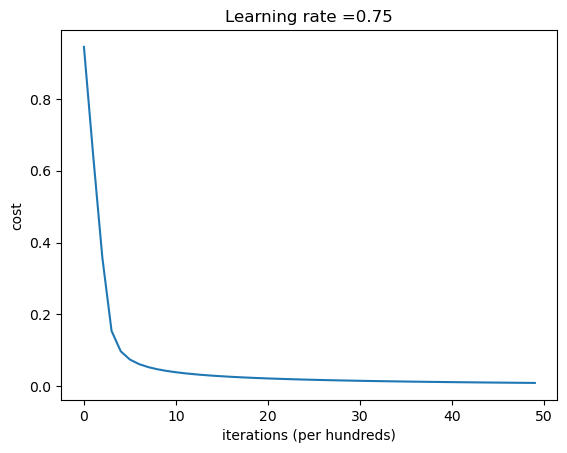

In [27]:
model = Model([2, 3, 3, 1], ["sigmoid", "sigmoid", "sigmoid"])
costs = train_model(model, X1, y1, num_iterations=5000, learning_rate=0.75)
draw_cost(costs, learning_rate=0.75)

In [12]:
pred_train = predict(X1, y1, model)

Iter0 |    Ground truth: 0 |    prediction: 0.00004
Iter1 |    Ground truth: 1 |    prediction: 0.99999
Iter2 |    Ground truth: 1 |    prediction: 0.99999
Iter3 |    Ground truth: 0 |    prediction: 0.00000
Iter4 |    Ground truth: 1 |    prediction: 0.99999
Iter5 |    Ground truth: 1 |    prediction: 0.99999
Iter6 |    Ground truth: 1 |    prediction: 0.99997
Iter7 |    Ground truth: 0 |    prediction: 0.00000
Iter8 |    Ground truth: 1 |    prediction: 0.99999
Iter9 |    Ground truth: 0 |    prediction: 0.00001
Iter10 |    Ground truth: 0 |    prediction: 0.00000
Iter11 |    Ground truth: 1 |    prediction: 0.99999
Iter12 |    Ground truth: 0 |    prediction: 0.00000
Iter13 |    Ground truth: 0 |    prediction: 0.00000
Iter14 |    Ground truth: 0 |    prediction: 0.00686
Iter15 |    Ground truth: 1 |    prediction: 0.99999
Iter16 |    Ground truth: 1 |    prediction: 0.99999
Iter17 |    Ground truth: 1 |    prediction: 0.83912
Iter18 |    Ground truth: 0 |    prediction: 0.00000
Ite

**Input 2**

In [13]:
model = Model([2, 3, 3, 1], ["sigmoid", "sigmoid", "sigmoid"])
costs = train_model(model, X2, y2, num_iterations=5000, learning_rate=0.75)

epoch 0 loss : 0.750110
epoch 100 loss : 0.691658
epoch 200 loss : 0.691342
epoch 300 loss : 0.690902
epoch 400 loss : 0.690216
epoch 500 loss : 0.689037
epoch 600 loss : 0.686794
epoch 700 loss : 0.682056
epoch 800 loss : 0.671079
epoch 900 loss : 0.645831
epoch 1000 loss : 0.602025
epoch 1100 loss : 0.555337
epoch 1200 loss : 0.519166
epoch 1300 loss : 0.493066
epoch 1400 loss : 0.473404
epoch 1500 loss : 0.457730
epoch 1600 loss : 0.444833
epoch 1700 loss : 0.433921
epoch 1800 loss : 0.423845
epoch 1900 loss : 0.410882
epoch 2000 loss : 0.260185
epoch 2100 loss : 0.137762
epoch 2200 loss : 0.087869
epoch 2300 loss : 0.061483
epoch 2400 loss : 0.045351
epoch 2500 loss : 0.034872
epoch 2600 loss : 0.027752
epoch 2700 loss : 0.022719
epoch 2800 loss : 0.019034
epoch 2900 loss : 0.016253
epoch 3000 loss : 0.014098
epoch 3100 loss : 0.012391
epoch 3200 loss : 0.011012
epoch 3300 loss : 0.009880
epoch 3400 loss : 0.008937
epoch 3500 loss : 0.008141
epoch 3600 loss : 0.007462
epoch 3700 lo

In [14]:
pred_train2 = predict(X2, y2, model)

Iter0 |    Ground truth: 0 |    prediction: 0.00074
Iter1 |    Ground truth: 1 |    prediction: 0.99872
Iter2 |    Ground truth: 0 |    prediction: 0.00054
Iter3 |    Ground truth: 1 |    prediction: 0.99871
Iter4 |    Ground truth: 0 |    prediction: 0.00069
Iter5 |    Ground truth: 1 |    prediction: 0.99867
Iter6 |    Ground truth: 0 |    prediction: 0.00181
Iter7 |    Ground truth: 1 |    prediction: 0.99844
Iter8 |    Ground truth: 0 |    prediction: 0.00636
Iter9 |    Ground truth: 1 |    prediction: 0.98155
Iter10 |    Ground truth: 0 |    prediction: 0.00990
Iter11 |    Ground truth: 0 |    prediction: 0.00669
Iter12 |    Ground truth: 1 |    prediction: 0.99040
Iter13 |    Ground truth: 0 |    prediction: 0.00346
Iter14 |    Ground truth: 1 |    prediction: 0.99997
Iter15 |    Ground truth: 0 |    prediction: 0.00190
Iter16 |    Ground truth: 1 |    prediction: 0.99998
Iter17 |    Ground truth: 0 |    prediction: 0.00120
Iter18 |    Ground truth: 1 |    prediction: 0.99997
Ite

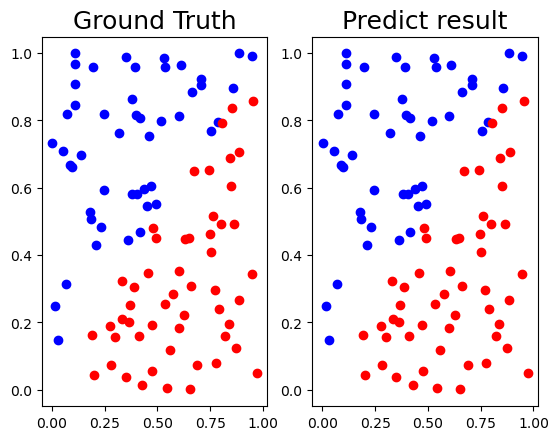

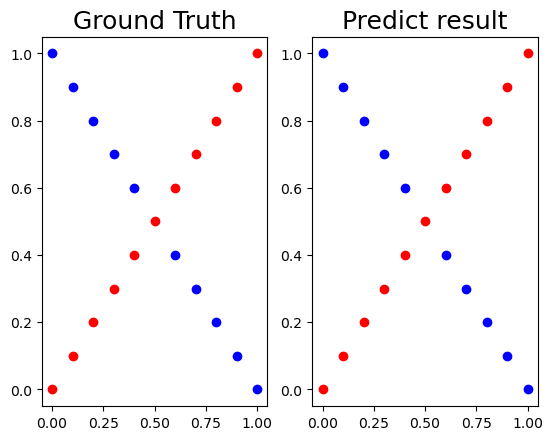

In [15]:
show_result(X1.T, y1.T, pred_train.T)
show_result(X2.T, y2.T, pred_train2.T)

# Bonus

**Relu Activation**

In [40]:
model = Model([2, 3, 3, 1], ["relu", "relu", "sigmoid"])
costs = train_model(model, X1, y1, num_iterations=5000, learning_rate=0.75)

Cost after iteration 0: 0.684618
Cost after iteration 100: 0.148939
Cost after iteration 200: 0.100189
Cost after iteration 300: 0.083017
Cost after iteration 400: 0.072652
Cost after iteration 500: 0.065239
Cost after iteration 600: 0.059525
Cost after iteration 700: 0.054914
Cost after iteration 800: 0.050928
Cost after iteration 900: 0.047826
Cost after iteration 1000: 0.044823
Cost after iteration 1100: 0.042230
Cost after iteration 1200: 0.040000
Cost after iteration 1300: 0.038007
Cost after iteration 1400: 0.036281
Cost after iteration 1500: 0.034688
Cost after iteration 1600: 0.033328
Cost after iteration 1700: 0.032133
Cost after iteration 1800: 0.030625
Cost after iteration 1900: 0.029406
Cost after iteration 2000: 0.028817
Cost after iteration 2100: 0.027801
Cost after iteration 2200: 0.027147
Cost after iteration 2300: 0.026445
Cost after iteration 2400: 0.025859
Cost after iteration 2500: 0.025180
Cost after iteration 2600: 0.024710
Cost after iteration 2700: 0.024089
Cost

**Momentum**

In [37]:
class LinearWithMomentum:
    def __init__(self, n_x, n_y):
        self.n_x = n_x
        self.n_y = n_y
        self.initialize_parameters()

    def initialize_parameters(self):
        # 
        self.W = np.random.randn(self.n_y, self.n_x) * np.sqrt(2. / self.n_x)
        self.b = np.zeros((self.n_y, 1))

        self.vdW = np.zeros_like(self.W)
        self.vdb = np.zeros_like(self.b)

    def forward(self, A):
        Z = np.matmul(self.W, A) + self.b
        self.cache = (A, self.W, self.b)
        return Z

    def backward(self, dZ):
        A_prev, W, b = self.cache
        m = A_prev.shape[1]
        self.dW = (1 / m) * np.matmul(dZ, A_prev.T)
        self.db = (1 / m) * np.sum(dZ, axis=1, keepdims=True)
        dA_prev = np.matmul(W.T, dZ)

        return dA_prev
    
    def update(self, learning_rate, beta=0.9):
        self.vdW = beta * self.vdW + (1 - beta) * self.dW
        self.vdb = beta * self.vdb + (1 - beta) * self.db
        self.W -= learning_rate * self.vdW
        self.b -= learning_rate * self.vdb

In [38]:
class ModelwithMomentum():
    def __init__(self, units, activation_functions):
        self.units = units
        self.activation_functions = activation_functions
        self.initialize_parameters()

    def initialize_parameters(self):
        self.linear = []
        self.activation = []
        for i in self.activation_functions:
            self.activation.append(Activation(i))
        for i in range(len(self.units)-1):
            self.linear.append(LinearWithMomentum(self.units[i], self.units[i+1]))
    
    def forward(self, X):
        A = X
        for i in range(len(self.linear)):
            A = self.linear[i].forward(A)
            A = self.activation[i].forward(A)
        return A
    
    def backward(self, AL=None, Y=None):
        L = len(self.linear)

        if self.activation_functions[-1] == "sigmoid":
            epsilon = 0.00001
            dAL = -(np.divide(Y, AL + epsilon) - np.divide(1 - Y, 1 - AL + epsilon))
            dZ = self.activation[-1].backward(dAL, Y)
            
            dA_prev = self.linear[-1].backward(dZ)
        else:
            dZ = self.activation[-1].backward(None, Y)

            dA_prev = self.linear[-1].backward(dZ)

        for  l in range(L-2, -1, -1):
            dZ = self.activation[l].backward(dA_prev, Y)
            dA_prev = self.linear[l].backward(dZ)

        return dA_prev
    
    def update(self, learning_rate, beta=0.9):
        L = len(self.linear)
        for i in range(L-1, -1, -1):
            self.linear[i].update(learning_rate, beta)

Cost after iteration 0: 0.892690
Cost after iteration 100: 0.065685
Cost after iteration 200: 0.031213
Cost after iteration 300: 0.021197
Cost after iteration 400: 0.016085
Cost after iteration 500: 0.012892
Cost after iteration 600: 0.010639
Cost after iteration 700: 0.008952
Cost after iteration 800: 0.007639
Cost after iteration 900: 0.006586
Cost after iteration 1000: 0.005728
Cost after iteration 1100: 0.005022
Cost after iteration 1200: 0.004434
Cost after iteration 1300: 0.003940
Cost after iteration 1400: 0.003521
Cost after iteration 1500: 0.003165
Cost after iteration 1600: 0.002859
Cost after iteration 1700: 0.002596
Cost after iteration 1800: 0.002367
Cost after iteration 1900: 0.002168
Cost after iteration 2000: 0.001994
Cost after iteration 2100: 0.001840
Cost after iteration 2200: 0.001705
Cost after iteration 2300: 0.001584
Cost after iteration 2400: 0.001476
Cost after iteration 2500: 0.001380
Cost after iteration 2600: 0.001293
Cost after iteration 2700: 0.001215
Cost

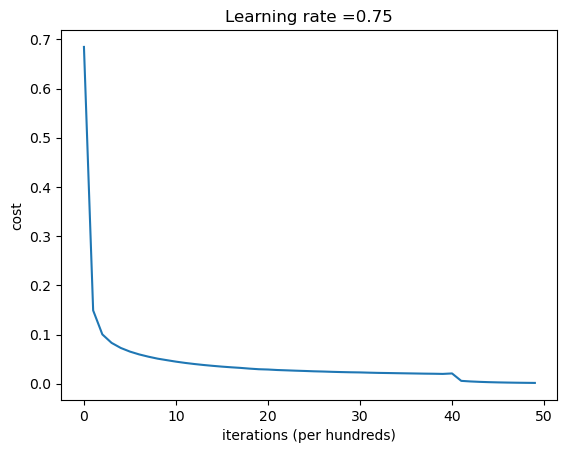

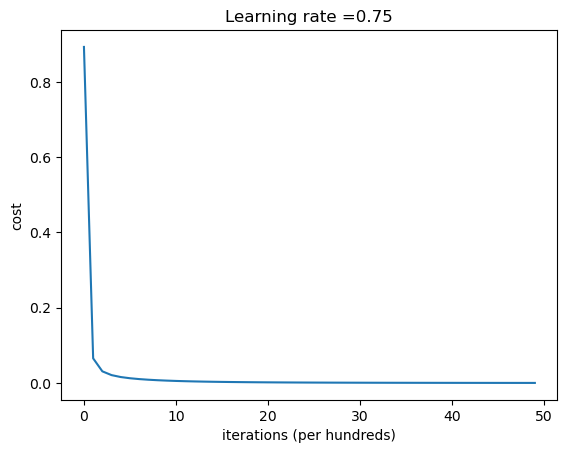

In [41]:
model = ModelwithMomentum([2, 3, 3, 1], ["relu", "relu", "sigmoid"])
costss = train_model(model, X1, y1, num_iterations=5000, learning_rate=0.75)
draw_cost(costs, learning_rate=0.75)
draw_cost(costss, learning_rate=0.75)

# Discussion

**Try different Learning rates**

Cost after iteration 0: 0.682963
Cost after iteration 100: 0.678234
Cost after iteration 200: 0.675998
Cost after iteration 300: 0.674781
Cost after iteration 400: 0.673973
Cost after iteration 500: 0.673324
Cost after iteration 600: 0.672732
Cost after iteration 700: 0.672154
Cost after iteration 800: 0.671572
Cost after iteration 900: 0.670981
Cost after iteration 1000: 0.670375
Cost after iteration 1100: 0.669753
Cost after iteration 1200: 0.669115
Cost after iteration 1300: 0.668459
Cost after iteration 1400: 0.667785
Cost after iteration 1500: 0.667092
Cost after iteration 1600: 0.666380
Cost after iteration 1700: 0.665647
Cost after iteration 1800: 0.664894
Cost after iteration 1900: 0.664119
Cost after iteration 2000: 0.663322
Cost after iteration 2100: 0.662502
Cost after iteration 2200: 0.661658
Cost after iteration 2300: 0.660790
Cost after iteration 2400: 0.659896
Cost after iteration 2500: 0.658976
Cost after iteration 2600: 0.658029
Cost after iteration 2700: 0.657054
Cost

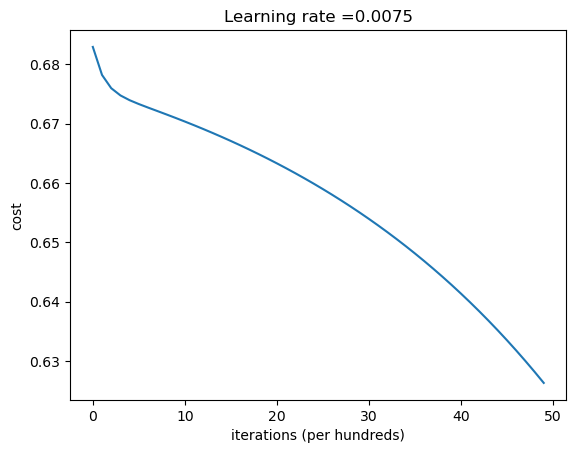

In [29]:
model = Model([2, 3, 3, 1], ["sigmoid", "sigmoid", "sigmoid"])
costs = train_model(model, X1, y1, num_iterations=5000, learning_rate=0.0075)
draw_cost(costs, learning_rate=0.0075)

Cost after iteration 0: 1.013886
Cost after iteration 100: 0.280850
Cost after iteration 200: 0.075865
Cost after iteration 300: 0.135327
Cost after iteration 400: 0.123677
Cost after iteration 500: 0.085285
Cost after iteration 600: 0.071533
Cost after iteration 700: 0.062707
Cost after iteration 800: 0.056013
Cost after iteration 900: 0.050594
Cost after iteration 1000: 0.046066
Cost after iteration 1100: 0.042120
Cost after iteration 1200: 0.038740
Cost after iteration 1300: 0.018744
Cost after iteration 1400: 0.012026
Cost after iteration 1500: 0.033738
Cost after iteration 1600: 0.017300
Cost after iteration 1700: 0.035224
Cost after iteration 1800: 0.022842
Cost after iteration 1900: 0.094253
Cost after iteration 2000: 0.023456
Cost after iteration 2100: 0.006279
Cost after iteration 2200: 0.023496
Cost after iteration 2300: 0.018538
Cost after iteration 2400: 0.028337
Cost after iteration 2500: 0.055881
Cost after iteration 2600: 0.020583
Cost after iteration 2700: 0.003834
Cost

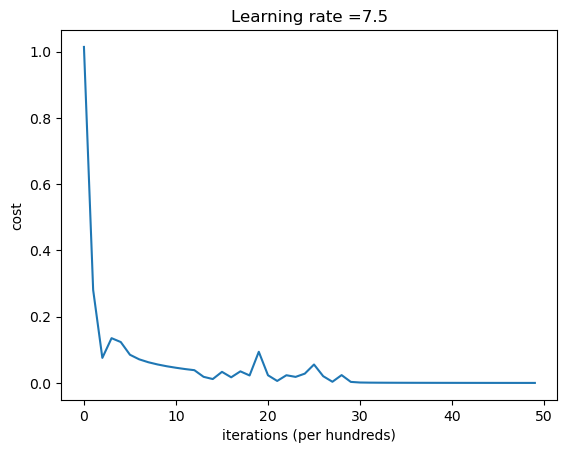

In [30]:
model = Model([2, 3, 3, 1], ["sigmoid", "sigmoid", "sigmoid"])
costs = train_model(model, X1, y1, num_iterations=5000, learning_rate=7.5)
draw_cost(costs, learning_rate=7.5)

**Try differnet numbers of hidden units**

Cost after iteration 0: 0.715845
Cost after iteration 100: 0.692101
Cost after iteration 200: 0.691998
Cost after iteration 300: 0.691993
Cost after iteration 400: 0.691993
Cost after iteration 500: 0.691993
Cost after iteration 600: 0.691993
Cost after iteration 700: 0.691993
Cost after iteration 800: 0.691993
Cost after iteration 900: 0.691993
Cost after iteration 1000: 0.691993
Cost after iteration 1100: 0.691993
Cost after iteration 1200: 0.691993
Cost after iteration 1300: 0.691993
Cost after iteration 1400: 0.691993
Cost after iteration 1500: 0.691993
Cost after iteration 1600: 0.691993
Cost after iteration 1700: 0.691993
Cost after iteration 1800: 0.691993
Cost after iteration 1900: 0.691993
Cost after iteration 2000: 0.691993
Cost after iteration 2100: 0.691993
Cost after iteration 2200: 0.691993
Cost after iteration 2300: 0.691993
Cost after iteration 2400: 0.691993
Cost after iteration 2500: 0.691993
Cost after iteration 2600: 0.691993
Cost after iteration 2700: 0.691993
Cost

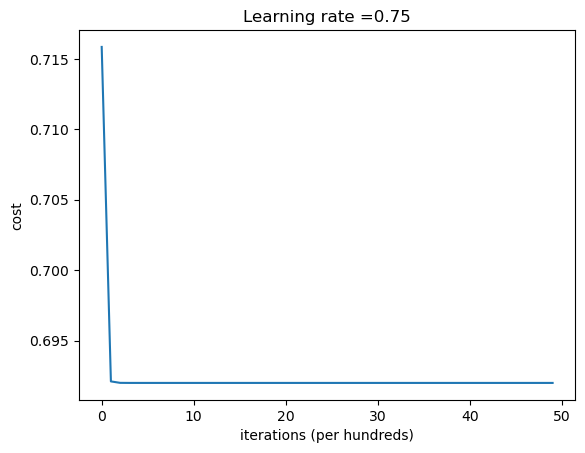

In [31]:
model = Model([2, 1], ["sigmoid"])
costs = train_model(model, X2, y2, num_iterations=5000, learning_rate=0.75)
draw_cost(costs, learning_rate=0.75)

Cost after iteration 0: 0.847832
Cost after iteration 100: 0.691961
Cost after iteration 200: 0.691915
Cost after iteration 300: 0.691861
Cost after iteration 400: 0.691792
Cost after iteration 500: 0.691703
Cost after iteration 600: 0.691586
Cost after iteration 700: 0.691428
Cost after iteration 800: 0.691210
Cost after iteration 900: 0.690904
Cost after iteration 1000: 0.690465
Cost after iteration 1100: 0.689817
Cost after iteration 1200: 0.688817
Cost after iteration 1300: 0.687181
Cost after iteration 1400: 0.684285
Cost after iteration 1500: 0.678665
Cost after iteration 1600: 0.667107
Cost after iteration 1700: 0.645438
Cost after iteration 1800: 0.616449
Cost after iteration 1900: 0.584802
Cost after iteration 2000: 0.545701
Cost after iteration 2100: 0.512251
Cost after iteration 2200: 0.489076
Cost after iteration 2300: 0.485961
Cost after iteration 2400: 0.469898
Cost after iteration 2500: 0.459351
Cost after iteration 2600: 0.450607
Cost after iteration 2700: 0.443233
Cost

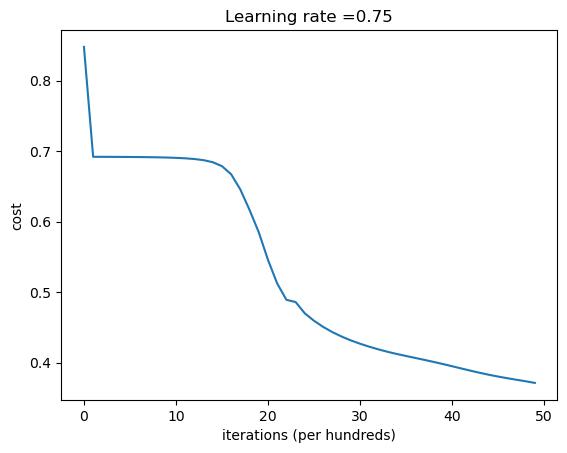

In [32]:
model = Model([2, 2, 2, 2, 1], ["sigmoid", "sigmoid", "sigmoid","sigmoid"])
costs = train_model(model, X2, y2, num_iterations=5000, learning_rate=0.75)
draw_cost(costs, learning_rate=0.75)

**Try without activation functions**

In [23]:
class ModelNoActivation():
    def __init__(self, units):
        self.units = units
        self.initialize_parameters()
        self.activation = Activation("sigmoid")

    def initialize_parameters(self):
        self.linear = []
        for i in range(len(self.units) - 1):
            self.linear.append(Linear(self.units[i], self.units[i+1]))

    def forward(self, X):
        A = X
        for i in range(len(self.linear)):
            A = self.linear[i].forward(A)
            if i == len(self.linear) - 1:
                A = self.activation.forward(A)
        return A

    def backward(self, AL=None, Y=None):
        L = len(self.linear)

        epsilon = 0.00001
        dAL = -(np.divide(Y, AL + epsilon) - np.divide(1 - Y, 1 - AL + epsilon))
        dZ = self.activation.backward(dAL, Y)
        
        dA_prev = self.linear[-1].backward(dZ)
        for  l in range(L-2, -1, -1):
            dA_prev = self.linear[l].backward(dA_prev)
        return dA_prev

    def update(self, learning_rate):
        for layer in self.linear:
            layer.update(learning_rate)

In [ ]:
def train_model(model, X, y, num_iterations=5000, learning_rate=0.75):
    costs = []
    if y.shape[0] != 1:
        y = y.T
    for i in range(num_iterations):
        # forward
        AL = model.forward(X)
        cost = compute_BCE_cost(AL, y)
        # backward
        model.backward(AL, y)
        # update
        model.update(learning_rate)
        if i % 100 == 0:
            print(f"Cost after iteration {i}: {cost:.6f}")
            costs.append(cost)
    return costs

Cost after iteration 0: 0.712175
Cost after iteration 100: 0.078427
Cost after iteration 200: 0.080465
Cost after iteration 300: 0.077103
Cost after iteration 400: 0.068322
Cost after iteration 500: 0.061935
Cost after iteration 600: 0.056912
Cost after iteration 700: 0.052781
Cost after iteration 800: 0.049284
Cost after iteration 900: 0.046267
Cost after iteration 1000: 0.043629
Cost after iteration 1100: 0.041301
Cost after iteration 1200: 0.039231
Cost after iteration 1300: 0.037383
Cost after iteration 1400: 0.035726
Cost after iteration 1500: 0.034236
Cost after iteration 1600: 0.032892
Cost after iteration 1700: 0.031678
Cost after iteration 1800: 0.030577
Cost after iteration 1900: 0.029576
Cost after iteration 2000: 0.028664
Cost after iteration 2100: 0.027830
Cost after iteration 2200: 0.027065
Cost after iteration 2300: 0.026361
Cost after iteration 2400: 0.025711
Cost after iteration 2500: 0.025109
Cost after iteration 2600: 0.024551
Cost after iteration 2700: 0.024031
Cost

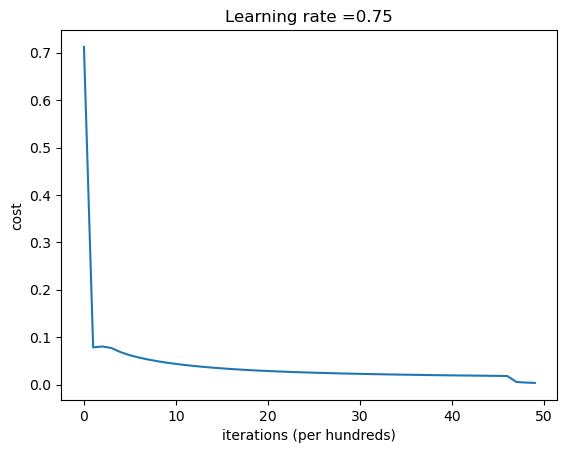

In [ ]:
model_no_activation = ModelNoActivation([2, 3, 3, 1])
costs_no_activation = train_model(model_no_activation, X1, y1, num_iterations=5000, learning_rate=0.75)
pred_no_activation = predict(X2, y2, model_no_activation)
draw_cost(costs_no_activation, learning_rate=0.75)   